In [76]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow import keras

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path='/content/drive/My Drive/Colab Notebooks/Loan Data DEC22-MAR23.xlsx' # importing our data
mar23 = pd.read_excel(path,'MAR23') # importing the first, march 2023 excel sheet
dec22 = pd.read_excel(path,'DEC22') # importing the second, dec 2022 excel sheet

In [5]:
dec22.head()

,cutoff_date,loan_id,loan_group,loan_program,orig_credit_score,loan_purpose_type,property_type,property_state,lien_position,original_cltv,...,orig_date,original_loan_term,rterm,original_interest_rate,current_interest_rate,delinquent_dt,days_delinquent,loan_status,original_dti_rate,charge off?
0,2022-12-30,loan_10000057796,NaN,PRIMARY,712,Debt consolidation,SFR,FL,Junior,0.7644,...,2022-02-15,120,110,0.0670,0.0670,NaT,0,IN_REPAY,0.2661,No
1,2022-12-30,loan_10000046566,NaN,PRIMARY,718,Debt consolidation,TOWNHOUSE/ROWHOUSE,MT,Junior,0.8996,...,2022-04-15,360,352,0.0820,0.0820,NaT,0,IN_REPAY,0.2869,No
2,2022-12-30,loan_10000041028,NaN,PRIMARY,650,Debt consolidation,CONDO,AZ,Junior,0.4856,...,2021-07-15,120,103,0.0700,0.0700,NaT,0,IN_REPAY,0.4910,No
3,2022-12-30,loan_10000067474,NaN,PRIMARY,680,Home improvement,SFR,FL,Junior,0.6394,...,2021-10-15,180,166,0.0664,0.0664,NaT,0,IN_REPAY,0.4993,No
4,2022-12-30,loan_10000047479,loan_10000092177,DRAW,770,Debt consolidation,SFR,IL,Junior,0.9000,...,2022-11-10,105,104,0.1030,0.1030,NaT,0,IN_REPAY,0.2032,No


In [6]:
mar23.shape

(95768, 24)

In [7]:
def combine_delq(df): # creates a new column in the dataframe checking if loan is delq
    df['Delq']=df.loan_status.apply(lambda x: 0 if "DELQ" in x else 1)
    # 0 if delinquent, 1 if not

In [8]:
combine_delq(mar23) # apply to both dataframes
combine_delq(dec22)

In [9]:
mar23.head()

,cutoff_date,loan_id,loan_group,loan_program,orig_credit_score,loan_purpose_type,property_type,property_state,lien_position,original_cltv,...,original_loan_term,rterm,original_interest_rate,current_interest_rate,delinquent_dt,days_delinquent,loan_status,original_dti_rate,Charge Off Hardcoded,Delq
0,2023-03-31,loan_10000000002,loan_10000071534,DRAW,831,Home improvement,SFR,CA,Junior,0.6733,...,172,0,0.0841,0.0841,NaT,0,PAID_CLOSED,0.4744,No,1
1,2023-03-31,loan_10000000003,NaN,PRIMARY,725,Home improvement,SFR,NJ,Junior,0.7138,...,360,353,0.0875,0.0875,NaT,0,IN_REPAY,0.2540,No,1
2,2023-03-31,loan_10000000004,loan_10000024216,DRAW,711,Home improvement,SFR,AZ,Junior,0.7771,...,100,91,0.0799,0.0799,NaT,0,IN_REPAY,0.2203,No,1
3,2023-03-31,loan_10000000005,NaN,PRIMARY,686,Debt consolidation,SFR,CO,Junior,0.6698,...,120,0,0.0825,0.0825,NaT,0,PAID_CLOSED,0.1493,No,1
4,2023-03-31,loan_10000000006,NaN,PRIMARY,703,Debt consolidation,SFR,FL,Junior,0.9000,...,180,0,0.1125,0.1125,NaT,0,PAID_CLOSED,0.2035,No,1


In [10]:
import sqlite3
conn=sqlite3.connect("delq.db") # creates a database connection

In [11]:
cursor=conn.cursor()
mar23.to_sql('mar23',conn,if_exists='replace',index=False)

95768

In [12]:
dec22.to_sql('dec22',conn,if_exists='replace',index=False) 

85310

In [34]:
# our sql query command for merging the two dataframes with the same loan ID's
cmd=\
"""
SELECT mar23.*, dec22.delq AS decDelq
FROM mar23 LEFT JOIN dec22 ON mar23.loan_id = dec22.loan_id
"""
loan_merged=pd.read_sql_query(cmd,conn)
loan_merged

,cutoff_date,loan_id,loan_group,loan_program,orig_credit_score,loan_purpose_type,property_type,property_state,lien_position,original_cltv,...,rterm,original_interest_rate,current_interest_rate,delinquent_dt,days_delinquent,loan_status,original_dti_rate,Charge Off Hardcoded,Delq,decDelq
0,2023-03-31 00:00:00,loan_10000000002,loan_10000071534,DRAW,831,Home improvement,SFR,CA,Junior,0.6733,...,0,0.0841,0.0841,None,0,PAID_CLOSED,0.4744,No,1,1.0
1,2023-03-31 00:00:00,loan_10000000003,None,PRIMARY,725,Home improvement,SFR,NJ,Junior,0.7138,...,353,0.0875,0.0875,None,0,IN_REPAY,0.2540,No,1,1.0
2,2023-03-31 00:00:00,loan_10000000004,loan_10000024216,DRAW,711,Home improvement,SFR,AZ,Junior,0.7771,...,91,0.0799,0.0799,None,0,IN_REPAY,0.2203,No,1,1.0
3,2023-03-31 00:00:00,loan_10000000005,None,PRIMARY,686,Debt consolidation,SFR,CO,Junior,0.6698,...,0,0.0825,0.0825,None,0,PAID_CLOSED,0.1493,No,1,1.0
4,2023-03-31 00:00:00,loan_10000000006,None,PRIMARY,703,Debt consolidation,SFR,FL,Junior,0.9000,...,0,0.1125,0.1125,None,0,PAID_CLOSED,0.2035,No,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95763,2023-03-31 00:00:00,loan_10000095765,None,PRIMARY,832,Debt consolidation,SFR,IL,Junior,0.8406,...,343,0.0786,0.0786,None,0,IN_REPAY,0.3528,No,1,1.0
95764,2023-03-31 00:00:00,loan_10000095766,None,PRIMARY,749,Home improvement,SFR,OH,Junior,0.9000,...,175,0.1106,0.1106,None,0,IN_REPAY,0.2717,No,1,1.0
95765,2023-03-31 00:00:00,loan_10000095767,None,PRIMARY,843,Home improvement,SFR,CA,Junior,0.0790,...,0,0.0635,0.0635,None,0,PAID_CLOSED,0.2008,No,1,1.0
95766,2023-03-31 00:00:00,loan_10000095768,None,PRIMARY,833,Other purchase,SFR,NC,Junior,0.6773,...,60,0.0901,0.0901,None,0,IN_REPAY,0.3548,No,1,NaN


In [82]:
conn.close()

In [35]:
def merge_delq_columns(df): # merges the two delq columns into one, checking if either are delq
  df["decDelq"] = df["decDelq"].fillna(2)
  df['decDelq'] = df['decDelq'].astype(int)
  df["Delq"] = np.minimum(df["Delq"], df["decDelq"])
  df.drop(columns =["decDelq"], inplace = True)

In [36]:
merge_delq_columns(loan_merged)
loan_merged.head(20)

,cutoff_date,loan_id,loan_group,loan_program,orig_credit_score,loan_purpose_type,property_type,property_state,lien_position,original_cltv,...,original_loan_term,rterm,original_interest_rate,current_interest_rate,delinquent_dt,days_delinquent,loan_status,original_dti_rate,Charge Off Hardcoded,Delq
0,2023-03-31 00:00:00,loan_10000000002,loan_10000071534,DRAW,831,Home improvement,SFR,CA,Junior,0.6733,...,172,0,0.0841,0.0841,None,0,PAID_CLOSED,0.4744,No,1
1,2023-03-31 00:00:00,loan_10000000003,None,PRIMARY,725,Home improvement,SFR,NJ,Junior,0.7138,...,360,353,0.0875,0.0875,None,0,IN_REPAY,0.2540,No,1
2,2023-03-31 00:00:00,loan_10000000004,loan_10000024216,DRAW,711,Home improvement,SFR,AZ,Junior,0.7771,...,100,91,0.0799,0.0799,None,0,IN_REPAY,0.2203,No,1
3,2023-03-31 00:00:00,loan_10000000005,None,PRIMARY,686,Debt consolidation,SFR,CO,Junior,0.6698,...,120,0,0.0825,0.0825,None,0,PAID_CLOSED,0.1493,No,1
4,2023-03-31 00:00:00,loan_10000000006,None,PRIMARY,703,Debt consolidation,SFR,FL,Junior,0.9000,...,180,0,0.1125,0.1125,None,0,PAID_CLOSED,0.2035,No,1
5,2023-03-31 00:00:00,loan_10000000007,loan_10000043174,DRAW,650,Debt consolidation,SFR,CA,Junior,0.6238,...,89,79,0.0925,0.0925,None,0,IN_REPAY,0.1711,No,1
6,2023-03-31 00:00:00,loan_10000000008,loan_10000074536,DRAW,727,Debt consolidation,CONDO,OR,Junior,0.9500,...,140,139,0.1171,0.1171,None,0,IN_REPAY,0.3723,No,1
7,2023-03-27 00:00:00,loan_10000000009,loan_10000034574,DRAW,717,Debt consolidation,CONDO,IL,Junior,0.9000,...,108,101,0.0945,0.0945,2023-01-24 00:00:00,63,TRANSFERRED,0.3186,No,1
8,2023-03-31 00:00:00,loan_10000000010,None,PRIMARY,741,Small Business,SFR,FL,Junior,0.8000,...,360,359,0.1022,0.1022,None,0,IN_REPAY,0.3969,No,1
9,2023-03-31 00:00:00,loan_10000000011,None,PRIMARY,815,Debt consolidation,TOWNHOUSE/ROWHOUSE,CO,Junior,0.7051,...,120,111,0.0575,0.0575,None,0,IN_REPAY,0.3149,No,1


In [37]:
list(loan_merged.columns)

['cutoff_date',
 'loan_id',
 'loan_group',
 'loan_program',
 'orig_credit_score',
 'loan_purpose_type',
 'property_type',
 'property_state',
 'lien_position',
 'original_cltv',
 'original_loan_bal',
 'loan_avail_draw_amount',
 'loan_draw_remaining_term',
 'prin_bal',
 'orig_date',
 'original_loan_term',
 'rterm',
 'original_interest_rate',
 'current_interest_rate',
 'delinquent_dt',
 'days_delinquent',
 'loan_status',
 'original_dti_rate',
 'Charge Off Hardcoded',
 'Delq']

In [38]:
# cleaning our data, dropping unneeded columns and converting all categorial vars into ints
def clean_data_for_ml(df): 
  df.drop(columns = ["cutoff_date",
                     "loan_id",
                     "loan_group",
                     "delinquent_dt",
                     "days_delinquent",
                     "loan_status"], inplace=True)
  le = LabelEncoder()
  for column in df.columns:
    if type(df[column][0]) == str:
      df[column] = le.fit_transform(df[column])

In [39]:
clean_data_for_ml(loan_merged)

In [40]:
loan_merged.head(20)

,loan_program,orig_credit_score,loan_purpose_type,property_type,property_state,lien_position,original_cltv,original_loan_bal,loan_avail_draw_amount,loan_draw_remaining_term,prin_bal,orig_date,original_loan_term,rterm,original_interest_rate,current_interest_rate,original_dti_rate,Charge Off Hardcoded,Delq
0,0,831,5,4,4,1,0.6733,50000.0,0.00,0,0.00,963,172,0,0.0841,0.0841,0.4744,0,1
1,1,725,5,4,28,1,0.7138,57119.0,0.00,53,56858.35,965,360,353,0.0875,0.0875,0.2540,0,1
2,0,711,5,4,3,1,0.7771,1500.0,4057.65,7,1401.09,929,100,91,0.0799,0.0799,0.2203,0,1
3,1,686,1,4,5,1,0.6698,56650.0,0.00,0,0.00,185,120,0,0.0825,0.0825,0.1493,0,1
4,1,703,1,4,8,1,0.9000,40122.0,0.00,0,0.00,266,180,0,0.1125,0.1125,0.2035,0,1
5,0,650,1,4,4,1,0.6238,1000.0,0.00,0,920.36,893,89,79,0.0925,0.0925,0.1711,0,1
6,0,727,1,0,33,1,0.9500,500.0,1861.37,7,497.29,1088,140,139,0.1171,0.1171,0.3723,0,1
7,0,717,1,0,12,1,0.9000,1000.0,0.00,17,977.96,960,108,101,0.0945,0.0945,0.3186,0,1
8,1,741,9,4,8,1,0.8000,32654.0,0.00,59,32535.72,1091,360,359,0.1022,0.1022,0.3969,0,1
9,1,815,1,5,5,1,0.7051,21447.0,1222.53,27,20224.47,914,120,111,0.0575,0.0575,0.3149,0,1


In [43]:
predictor_labels = ["loan_program",
                    "orig_credit_score",
                    "loan_purpose_type",
                    "property_type",
                    "property_state",
                    "lien_position",
                    "original_cltv",
                    "original_loan_bal",
                    "loan_avail_draw_amount",
                    "loan_draw_remaining_term",
                    "prin_bal",
                    "orig_date",
                    "original_loan_term",
                    "rterm",
                    "original_interest_rate",
                    "current_interest_rate" ,
                    "original_dti_rate" ,
                    "Charge Off Hardcoded"]

<Axes: xlabel='Delq', ylabel='count'>

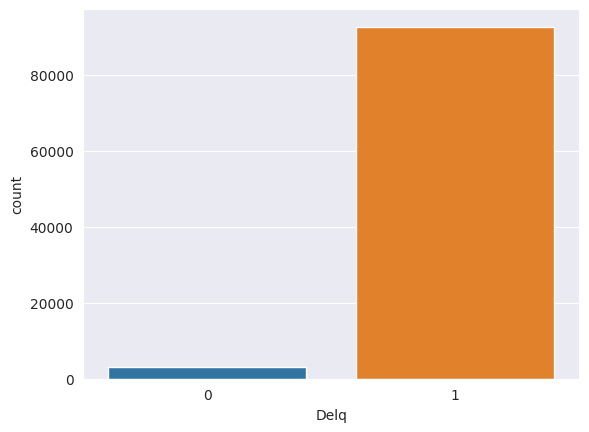

In [48]:
# looking at the spread of our data of delinquents versus non
sns.set_style("darkgrid")
sns.countplot(x = "Delq", data = loan_merged)

Trying Balanced Bagging Classifier to resample our data with a Decision Tree Classifier model.

In [49]:
from sklearn.utils import resample

In [61]:
loan_merged = loan_merged.dropna() # dropping nan rows (minimal percentage of the data)

In [63]:
# splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    loan_merged[predictor_labels], loan_merged["Delq"], stratify=loan_merged["Delq"], random_state=0)

In [64]:
from sklearn.model_selection import cross_validate

In [70]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

# applying a decision tree model
tree = DecisionTreeClassifier()
resampled_rf = BalancedBaggingClassifier(estimator=tree,
                                         random_state=0)

# scoring ouur mdoel on different accuracy metrics
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10,
                        scoring=('roc_auc', 'average_precision', "balanced_accuracy"))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean(), scores["test_balanced_accuracy"].mean()

(0.9203272109065228, 0.9957749330946699, 0.8596509069866686)

Now we looked at trying over-sampling, which may be too drastic for our data due to the low percentage of delinquent data points. Here, we also applied a Keras Sequential model.

Random over-sampling:
0    92282
1    92282
Name: Delq, dtype: int64


<Axes: xlabel='Delq', ylabel='count'>

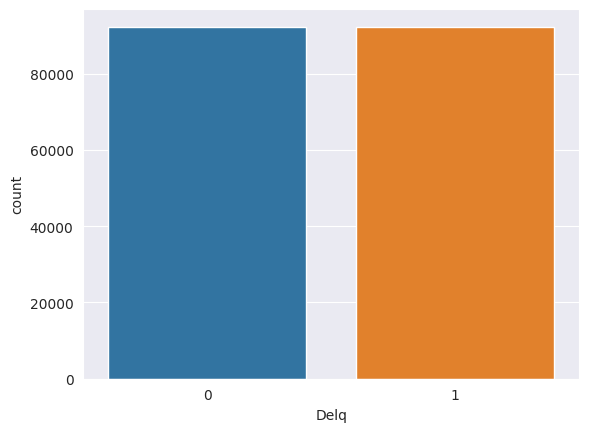

In [72]:
# over sampling, amplifying the small amount of delinquent data to match non-delq
count_class_nondelq, count_class_delq = loan_merged['Delq'].value_counts()
df_delq = loan_merged[loan_merged['Delq'] == 0]
df_nondelq = loan_merged[loan_merged['Delq'] == 1]
df_delq_over = df_delq.sample(count_class_nondelq, replace=True)
df_test_over = pd.concat([df_delq_over, df_nondelq], axis=0)
print('Random over-sampling:')
print(df_test_over['Delq'].value_counts())

sns.set_style('darkgrid')
sns.countplot(x='Delq', data=df_test_over)

<Axes: >

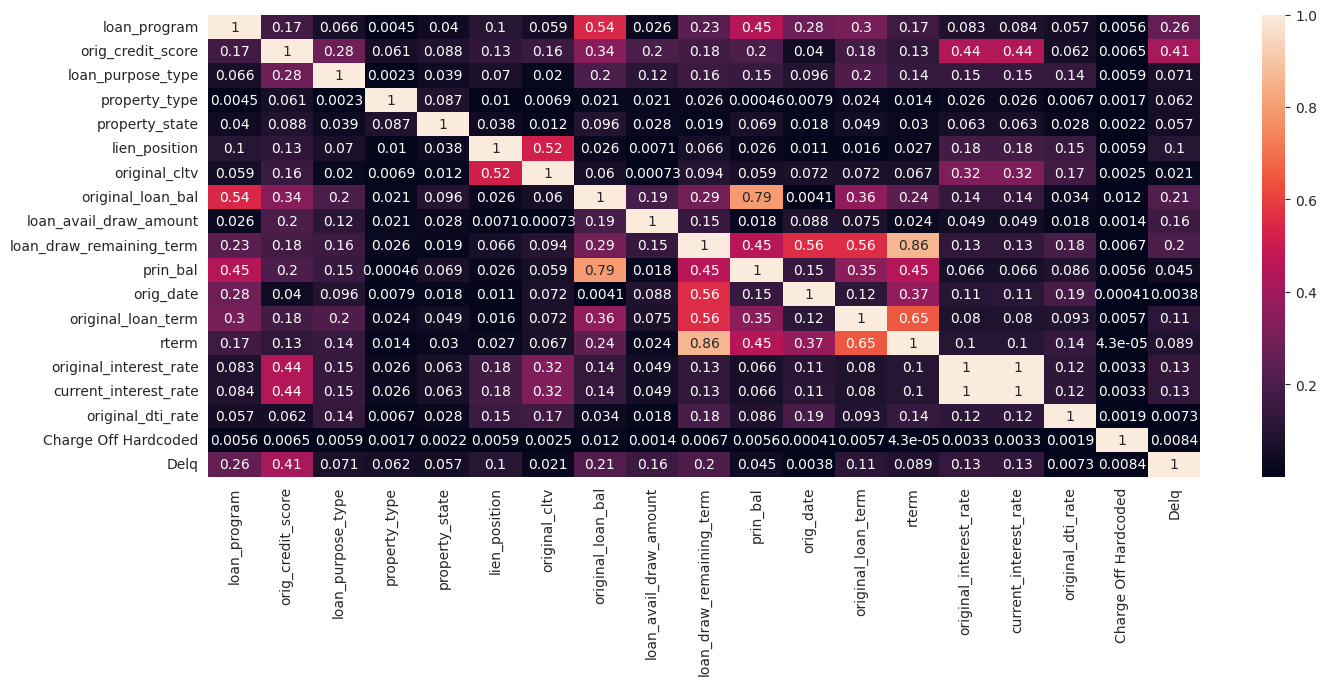

In [80]:
# looking at correlations between the different variables
corr = df_test_over.corr().abs()
plt.figure(figsize = (16, 6))
sns.heatmap(corr, annot = True)

In [78]:
#splitting our data and applying keras sequential modeling with dense layers

to_train = df_test_over[df_test_over['Delq'].isin([0,1])]
to_pred = df_test_over[df_test_over['Delq'] == 2]

X = to_train.drop('Delq', axis=1).values
y = to_train['Delq'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 101)

scaler = sklearn.preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = tf.keras.Sequential([
    layers.Dense(18, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(5, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
        optimizer='adam', 
        loss='binary_crossentropy', 
        metrics=['accuracy']
)
model.fit(
        X_train, 
        y_train, 
        epochs=20, 
        batch_size=256, 
        validation_data=(X_test, y_test)
)

Epoch 1/20
505/505 [==============================] - 3s 5ms/step - loss: 0.6098 - accuracy: 0.6833 - val_loss: 0.5150 - val_accuracy: 0.7545
Epoch 2/20
505/505 [==============================] - 2s 4ms/step - loss: 0.4943 - accuracy: 0.7679 - val_loss: 0.4752 - val_accuracy: 0.7818
Epoch 3/20
505/505 [==============================] - 2s 3ms/step - loss: 0.4636 - accuracy: 0.7872 - val_loss: 0.4531 - val_accuracy: 0.7927
Epoch 4/20
505/505 [==============================] - 1s 3ms/step - loss: 0.4460 - accuracy: 0.7966 - val_loss: 0.4380 - val_accuracy: 0.8019
Epoch 5/20
505/505 [==============================] - 1s 3ms/step - loss: 0.4335 - accuracy: 0.8042 - val_loss: 0.4284 - val_accuracy: 0.8098
Epoch 6/20
505/505 [==============================] - 1s 3ms/step - loss: 0.4229 - accuracy: 0.8113 - val_loss: 0.4191 - val_accuracy: 0.8144
Epoch 7/20
505/505 [==============================] - 1s 3ms/step - loss: 0.4144 - accuracy: 0.8171 - val_loss: 0.4087 - val_accuracy: 0.8223
Epoch 